链家二手房数据分析（一）房价预测

首先导入要使用的科学计算包`numpy`,`pandas`,可视化`matplotlib`,`seaborn`,以及机器学习包`sklearn`。

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib.font_manager import _rebuild
_rebuild()
import matplotlib.pyplot as plt
from IPython.display import display
plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif':['SimHei','Arial']})
%matplotlib inline

然后导入数据，并进行初步的观察，这些观察包括了解数据特征的`缺失值`，`异常值`，以及大概的`描述性统计`。

In [21]:
# 导入链家二手房数据
lianjia_df = pd.read_csv('lianjia.csv')
display(lianjia_df.head(n=2))

,Direction,District,Elevator,Floor,Garden,Id,Layout,Price,Region,Renovation,Size,Year
0,东西,灯市口,NaN,6,锡拉胡同21号院,101102647043,3室1厅,780.0,东城,精装,75.0,1988
1,南北,东单,无电梯,6,东华门大街,101102650978,2室1厅,705.0,东城,精装,60.0,1988


初步观察到一共有`11`个特征变量，`Price` 在这里是我们的目标变量，然后我们继续深入观察一下。

In [22]:
# 检查缺失值情况
lianjia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23677 entries, 0 to 23676
Data columns (total 12 columns):
Direction     23677 non-null object
District      23677 non-null object
Elevator      15440 non-null object
Floor         23677 non-null int64
Garden        23677 non-null object
Id            23677 non-null int64
Layout        23677 non-null object
Price         23677 non-null float64
Region        23677 non-null object
Renovation    23677 non-null object
Size          23677 non-null float64
Year          23677 non-null int64
dtypes: float64(2), int64(3), object(7)
memory usage: 2.2+ MB


发现了数据集一共有`23677`条数据，其中`Elevator`特征有明显的缺失值。

In [23]:
lianjia_df.describe()

,Floor,Id,Price,Size,Year
count,23677.000000,2.367700e+04,23677.000000,23677.000000,23677.000000
mean,12.765088,1.011024e+11,610.668319,99.149301,2001.326519
std,7.643932,5.652477e+05,411.452107,50.988838,9.001996
min,1.000000,1.010886e+11,60.000000,2.000000,1950.000000
25%,6.000000,1.011022e+11,365.000000,66.000000,1997.000000
50%,11.000000,1.011025e+11,499.000000,88.000000,2003.000000
75%,18.000000,1.011027e+11,717.000000,118.000000,2007.000000
max,57.000000,1.011028e+11,6000.000000,1019.000000,2017.000000


上面结果给出了特征值是数值的一些统计值，包括平均数，标准差，中位数，最小值，最大值，25%分位数，75%分位数。这些统计结果简单直接，对于初始了解一个特征好坏非常有用，比如我们观察到 `Size` 特征 的最大值为1019平米，最小值为2平米，那么我们就要思考这个在实际中是不是存在的，如果不存在没有意义，那么这个数据就是一个异常值，会严重影响模型的性能。

当然，这只是初步观察，后续我们会用数据可视化来清晰的展示，并证实我们的猜测。

In [24]:
# 添加新特征房屋均价
df = lianjia_df.copy()
df['PerPrice'] = lianjia_df['Price']/lianjia_df['Size']

# 重新摆放列位置
columns = ['Region', 'District', 'Garden', 'Layout', 'Floor', 'Year', 'Size', 'Elevator', 'Direction', 'Renovation', 'PerPrice', 'Price']
df = pd.DataFrame(df, columns = columns)

# 重新审视数据集
display(df.head(n=2))

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
0,东城,灯市口,锡拉胡同21号院,3室1厅,6,1988,75.0,NaN,东西,精装,10.40,780.0
1,东城,东单,东华门大街,2室1厅,6,1988,60.0,无电梯,南北,精装,11.75,705.0


我们发现 `Id` 特征其实没有什么实际意义，所以将其移除。由于房屋单价分析起来比较方便，简单的使用总价/面积就可得到，所以增加一个新的特征 `PerPrice`（只用于分析，不是预测特征）。另外，特征的顺序也被调整了一下，看起来比较舒服。

## 数据可视化分析
### Region特征分析

对于区域特征，我们可以分析不同区域房价和数量的对比。

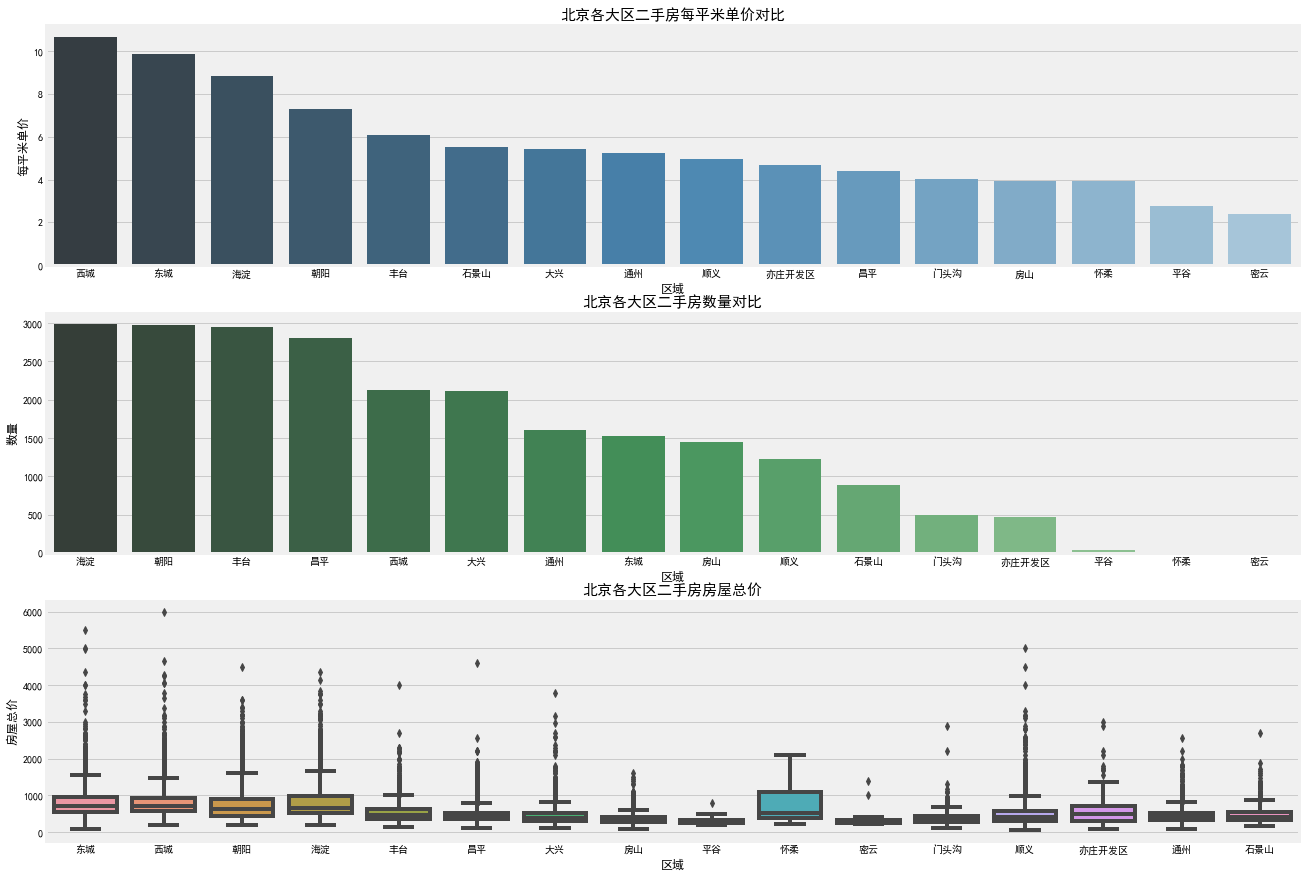

In [25]:
# 对二手房区域分组对比二手房数量和每平米房价
df_house_count = df.groupby('Region')['Price'].count().sort_values(ascending=False).to_frame().reset_index()
df_house_mean = df.groupby('Region')['PerPrice'].mean().sort_values(ascending=False).to_frame().reset_index()

f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,15))
sns.barplot(x='Region', y='PerPrice', palette="Blues_d", data=df_house_mean, ax=ax1)
ax1.set_title('北京各大区二手房每平米单价对比',fontsize=15)
ax1.set_xlabel('区域')
ax1.set_ylabel('每平米单价')

sns.barplot(x='Region', y='Price', palette="Greens_d", data=df_house_count, ax=ax2)
ax2.set_title('北京各大区二手房数量对比',fontsize=15)
ax2.set_xlabel('区域')
ax2.set_ylabel('数量')

sns.boxplot(x='Region', y='Price', data=df, ax=ax3)
ax3.set_title('北京各大区二手房房屋总价',fontsize=15)
ax3.set_xlabel('区域')
ax3.set_ylabel('房屋总价')

plt.show()

使用了`pandas`的网络透视功能 `groupby` 分组排序。区域特征可视化直接采用 `seaborn` 完成，颜色使用调色板 `palette` 参数，颜色渐变，越浅说明越少，反之越多。
可以观察到：
- **二手房均价**：西城区的房价最贵均价大约11万/平，因为西城在二环以里，且是热门学区房的聚集地。其次是东城大约10万/平，然后是海淀大约8.5万/平，其它均低于8万/平。
- **二手房房数量**：从数量统计上来看，目前二手房市场上比较火热的区域。海淀区和朝阳区二手房数量最多，差不多都接近3000套，毕竟大区，需求量也大。然后是丰台区，近几年正在改造建设，有赶超之势。
- **二手房总价**：通过箱型图看到，各大区域房屋总价中位数都在1000万以下，且房屋总价离散值较高，西城最高达到了6000万，说明房屋价格特征不是理想的正太分布。


## Size特征分析

/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


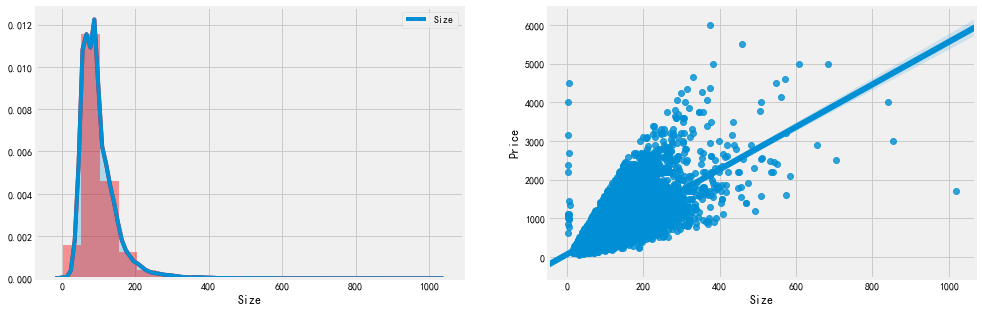

In [26]:
f, [ax1,ax2] = plt.subplots(1, 2, figsize=(15, 5))
# 建房时间的分布情况
sns.distplot(df['Size'], bins=20, ax=ax1, color='r')
sns.kdeplot(df['Size'], shade=True, ax=ax1)
# 建房时间和出售价格的关系
sns.regplot(x='Size', y='Price', data=df, ax=ax2)
plt.show()

`Size` 分布：

通过 `distplot`  和 `kdeplot` 绘制柱状图观察 `Size` 特征的分布情况，属于长尾类型的分布，这说明了有很多面积很大且超出正常范围的二手房。

`Size` 与 `Price` 的关系：

通过 `regplot` 绘制了 `Size` 和 `Price` 之间的散点图，发现 `Size` 特征基本与 `Price` 呈现线性关系，符合基本常识，面积越大，价格越高。但是有两组明显的异常点：1. 面积不到10平米，但是价格超出10000万；2. 一个点面积超过了1000平米，价格很低，需要查看是什么情况。

In [27]:
df.loc[df['Size']< 10]

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
1168,房山,长阳,世茂维拉,叠拼别墅,5,2015,5.0,毛坯,240.97平米,南北,216.000000,1080.0
1458,房山,长阳,世茂维拉,叠拼别墅,5,2015,5.0,毛坯,242.78平米,南北,220.000000,1100.0
1797,房山,长阳,世茂维拉,叠拼别墅,5,2015,5.0,精装,242.96平米,南北,196.000000,980.0
2268,顺义,顺义其它,龙湖好望山,叠拼别墅,4,2014,4.0,精装,295.88平米,南北,250.000000,1000.0
2274,顺义,顺义其它,鹭峯国际,叠拼别墅,4,2014,5.0,精装,295.01平米,南北,290.000000,1450.0
2276,顺义,顺义其它,龙湖好望山,叠拼别墅,3,2014,4.0,毛坯,292.31平米,南北,215.000000,860.0
2432,顺义,顺义其它,龙湖好望山,叠拼别墅,5,2013,6.0,精装,294.42平米,南北,163.333333,980.0
4078,大兴,西红门,鸿坤林语墅,叠拼别墅,3,2015,4.0,精装,427.5平米,南北,787.500000,3150.0
4079,大兴,西红门,鸿坤林语墅,叠拼别墅,4,2015,4.0,精装,361.8平米,南北,595.000000,2380.0
4761,大兴,西红门,鸿坤林语墅,叠拼别墅,3,2015,5.0,精装,386.83平米,南北,540.000000,2700.0


经过查看发现这组数据是别墅，出现异常的原因是由于别墅结构比较特殊（无朝向无电梯），字段定义与二手商品房不太一样导致爬虫爬取数据错位。也因别墅类型二手房不在我们的考虑范围之内，故将其移除再次观察`Size`分布和`Price`关系。

In [28]:
df.loc[df['Size']>1000]

,Region,District,Garden,Layout,Floor,Year,Size,Elevator,Direction,Renovation,PerPrice,Price
8754,通州,通州其它,新华联科技大厦,1房间0卫,8,2009,1019.0,有电梯,南,简装,1.668302,1700.0


经观察这个异常点不是普通的民用二手房，很可能是商用房，所以才有1房间0厅确有如此大超过1000平米的面积，这里选择移除。

In [29]:
df = df[(df['Layout']!='叠拼别墅')&(df['Size']<1000)]

/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


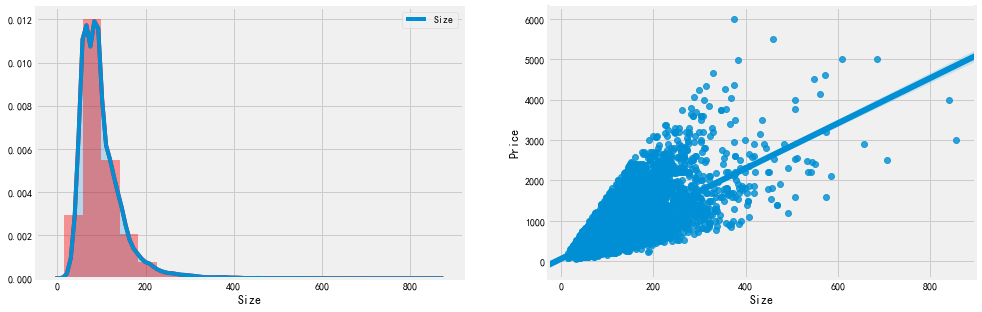

In [30]:
f, [ax1,ax2] = plt.subplots(1, 2, figsize=(15, 5))
# 建房时间的分布情况
sns.distplot(df['Size'], bins=20, ax=ax1, color='r')
sns.kdeplot(df['Size'], shade=True, ax=ax1)
# 建房时间和出售价格的关系
sns.regplot(x='Size', y='Price', data=df, ax=ax2)
plt.show()

重新进行可视化发现就没有明显的异常点了。

## Layout特征分析

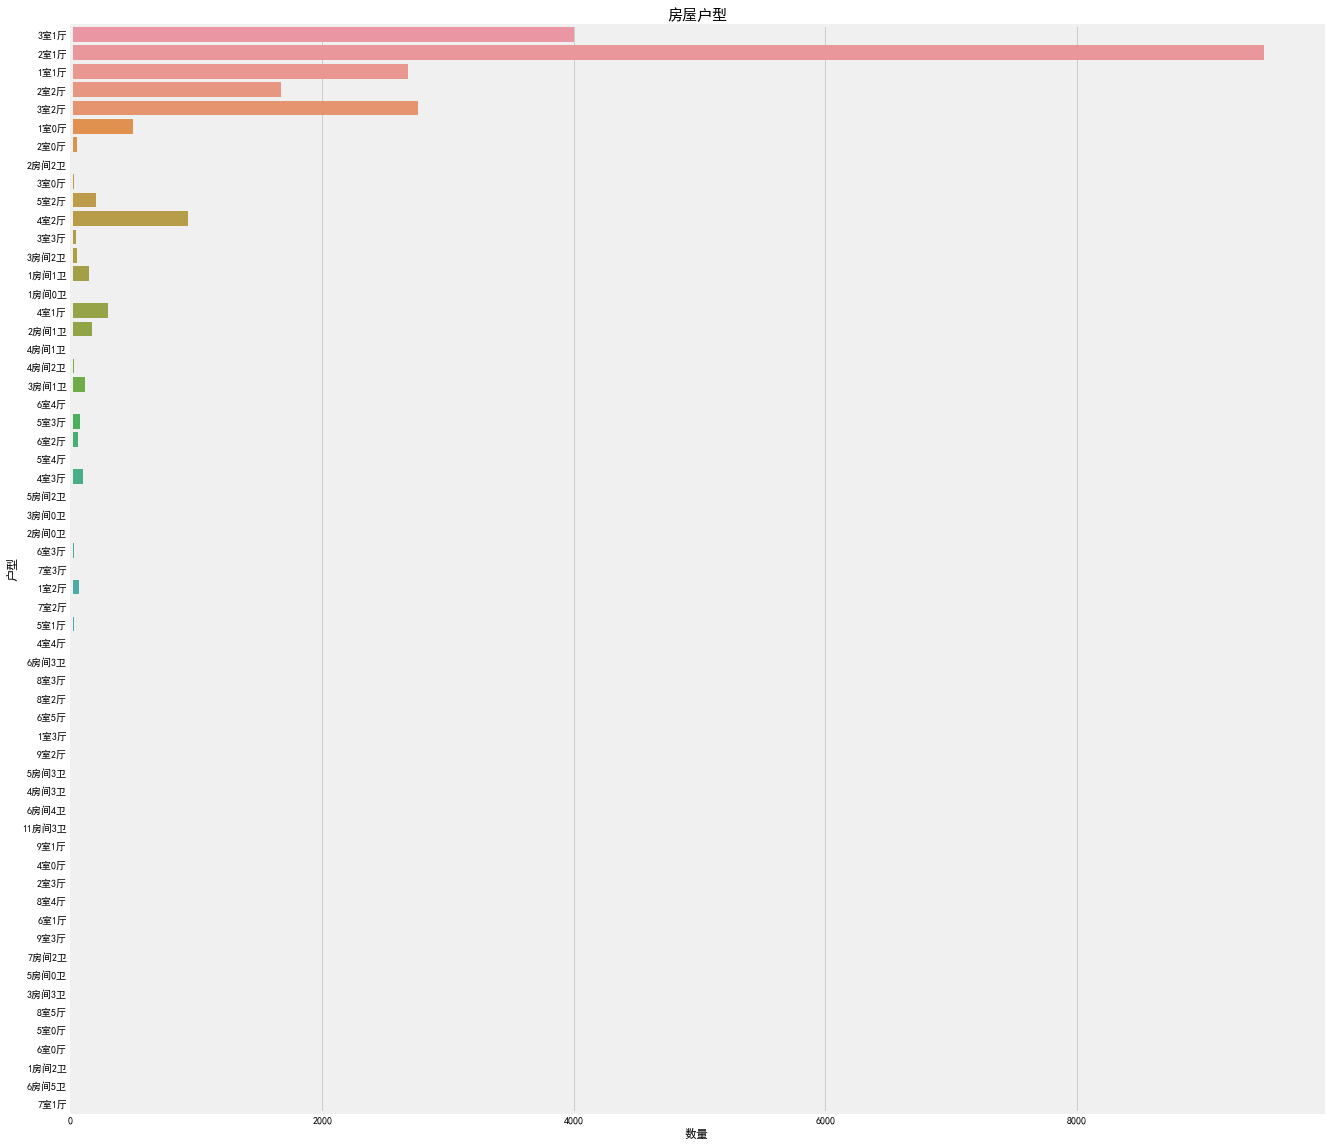

In [31]:
f, ax1= plt.subplots(figsize=(20,20))
sns.countplot(y='Layout', data=df, ax=ax1)
ax1.set_title('房屋户型',fontsize=15)
ax1.set_xlabel('数量')
ax1.set_ylabel('户型')
plt.show()

这个特征真是不看不知道，各种厅室组合搭配，竟然还有9室3厅，4室0厅等奇怪的结构。其中，2室一厅占绝大部分，其次是3室一厅，2室2厅，3室两厅。但是仔细观察特征分类下有很多不规则的命名，比如2室一厅与2房间1卫，还有别墅，没有统一的叫法。这样的特征肯定是不能作为机器学习模型的数据输入的，需要使用特征工程进行相应的处理。

## `Renovation` 特征分析

In [32]:
df['Renovation'].value_counts()

精装    11345
简装     8496
其他     3239
毛坯      576
Name: Renovation, dtype: int64

发现`Renovation`装修特征中竟然有南北，它属于朝向的类型，可能是因为爬虫过程中一些信息位置为空，导致`“Direction”`朝向特征出现在这里，所以需要`清除`或`替换掉`。

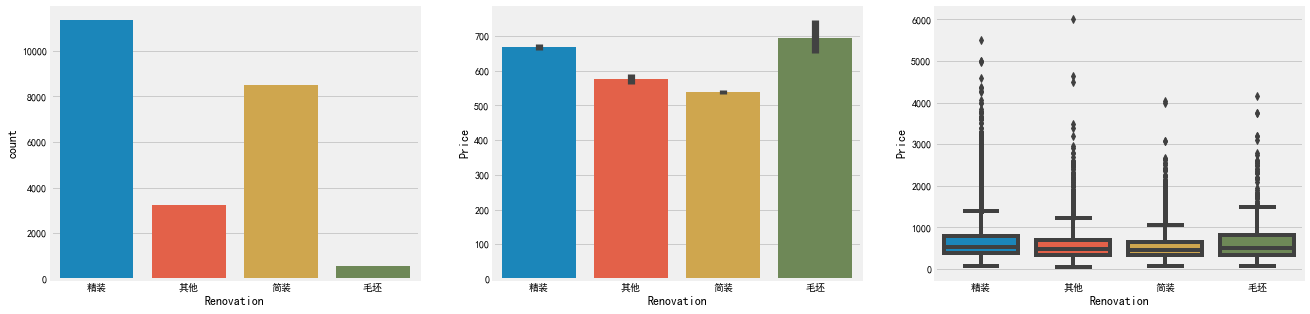

In [33]:
# 去掉错误数据“南北”，因为爬虫过程中一些信息位置为空，导致“Direction”的特征出现在这里，需要清除或替换
df['Renovation'] = df.loc[(df['Renovation'] != '南北'), 'Renovation']

# 画幅设置
f, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(df['Renovation'], ax=ax1)
sns.barplot(x='Renovation', y='Price', data=df, ax=ax2)
sns.boxplot(x='Renovation', y='Price', data=df, ax=ax3)
plt.show()

观察到，精装修的二手房数量最多，简装其次，也是我们平日常见的。而对于价格来说，毛坯类型却是最高，其次是精装修。

## `Elevator` 特征分析

初探数据的时候，我们发现 `Elevator` 特征是有大量缺失值的，这对于我们是十分不利的，首先我们先看看有多少缺失值：

In [34]:
misn = len(df.loc[(df['Elevator'].isnull()), 'Elevator'])
print('Elevator缺失值数量为：'+ str(misn))

Elevator缺失值数量为：8237


`Elevator` 缺失值数量为：`8237`

这么多的缺失值怎么办呢？这个需要根据实际情况考虑，常用的方法有`平均值/中位数填补法，直接移除，或者根据其他特征建模预测等。`

这里我们考虑填补法，但是有无电梯不是数值，不存在平均值和中位数，怎么填补呢？这里给大家提供一种思路：`就是根据楼层 Floor 来判断有无电梯，一般的楼层大于6的都有电梯，而小于等于6层的一般都没有电梯`。有了这个标准，那么剩下的就简单了。

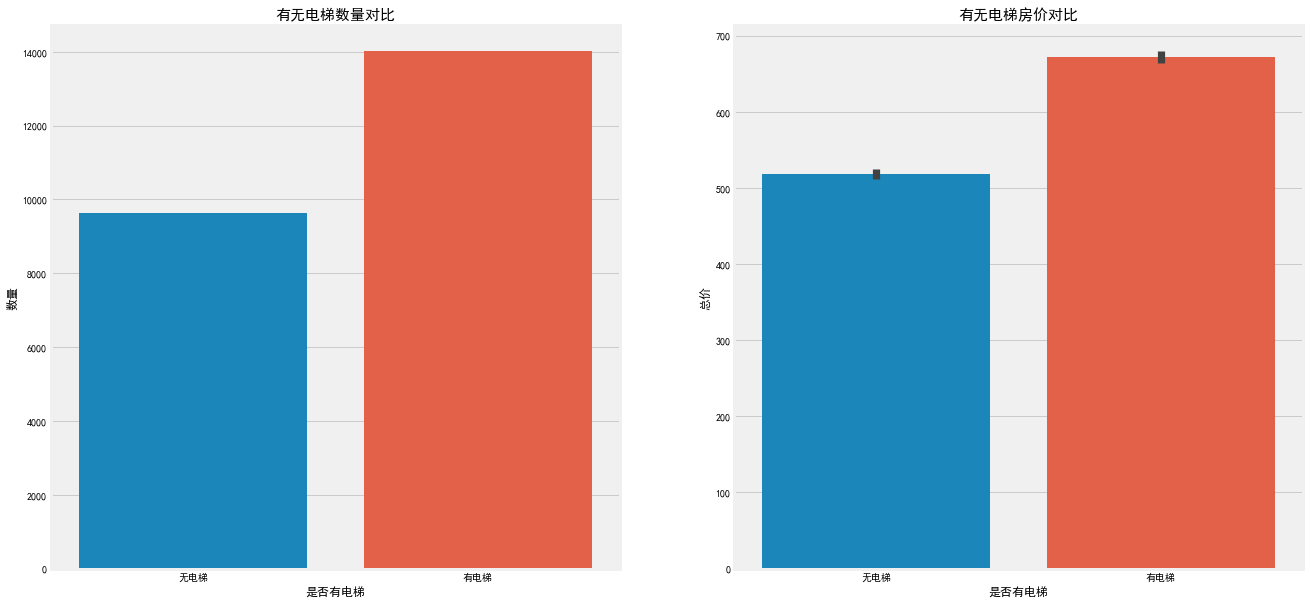

In [35]:
# 由于存在个别类型错误，如简装和精装，特征值错位，故需要移除
df['Elevator'] = df.loc[(df['Elevator'] == '有电梯')|(df['Elevator'] == '无电梯'), 'Elevator']

# 填补Elevator缺失值
df.loc[(df['Floor']>6)&(df['Elevator'].isnull()), 'Elevator'] = '有电梯'
df.loc[(df['Floor']<=6)&(df['Elevator'].isnull()), 'Elevator'] = '无电梯'

f, [ax1,ax2] = plt.subplots(1, 2, figsize=(20, 10))
sns.countplot(df['Elevator'], ax=ax1)
ax1.set_title('有无电梯数量对比',fontsize=15)
ax1.set_xlabel('是否有电梯')
ax1.set_ylabel('数量')
sns.barplot(x='Elevator', y='Price', data=df, ax=ax2)
ax2.set_title('有无电梯房价对比',fontsize=15)
ax2.set_xlabel('是否有电梯')
ax2.set_ylabel('总价')
plt.show()

结果观察到，有电梯的二手房数量居多一些，毕竟高层土地利用率比较高，适合北京庞大的人群需要，而高层就需要电梯。相应的，有电梯二手房房价较高，因为电梯前期装修费和后期维护费包含内了（但这个价格比较只是一个平均的概念，比如无电梯的6层豪华小区当然价格更高了）。

## `Year` 特征分析

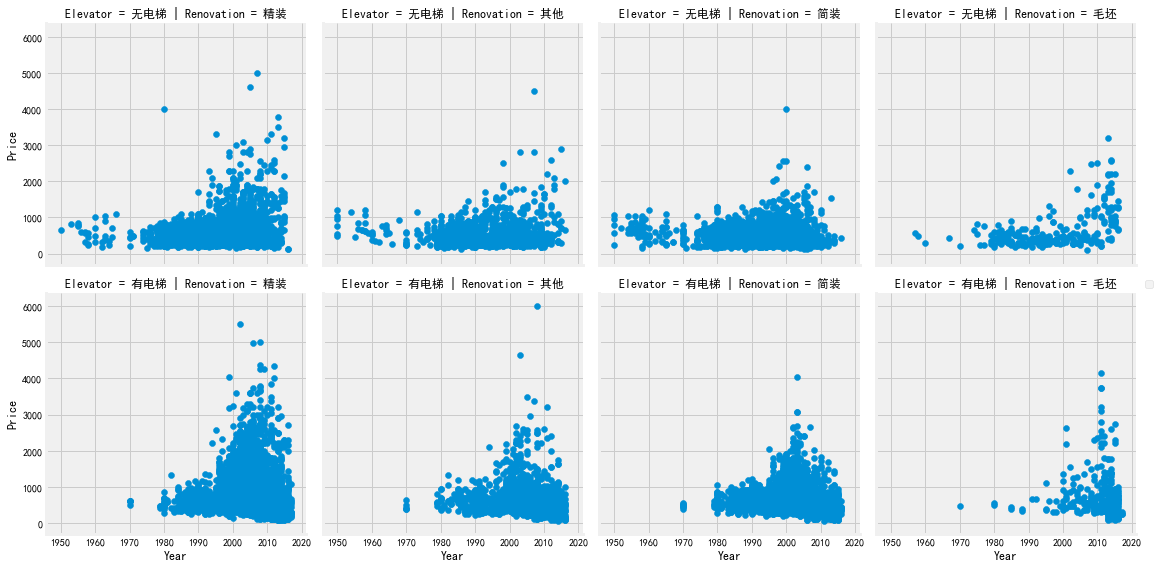

In [36]:
grid = sns.FacetGrid(df, row='Elevator', col='Renovation', palette='seismic',size=4)
grid.map(plt.scatter, 'Year', 'Price')
grid.add_legend()

在Renovation和Elevator的分类条件下，使用 FaceGrid 分析 Year 特征，观察结果如下：
整个二手房房价趋势是随着时间增长而增长的；

- 2000年以后建造的二手房房价相较于2000年以前有很明显的价格上涨；

- 1980年之前几乎不存在有电梯二手房数据，说明1980年之前还没有大面积安装电梯；

- 1980年之前无电梯二手房中，简装二手房占绝大多数，精装反而很少；

## `Floor` 特征分析

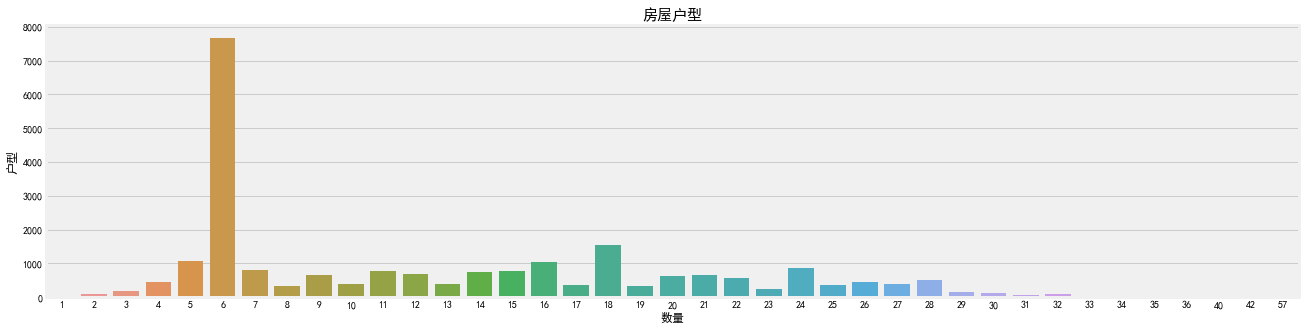

In [37]:
f, ax1= plt.subplots(figsize=(20,5))
sns.countplot(x='Floor', data=df, ax=ax1)
ax1.set_title('房屋户型',fontsize=15)
ax1.set_xlabel('数量')
ax1.set_ylabel('户型')
plt.show()

可以看到，6层二手房数量最多，但是单独的楼层特征没有什么意义，因为每个小区住房的总楼层数都不一样，我们需要知道楼层的相对意义。另外，楼层与文化也有很重要联系，比如中国文化七上八下，七层可能受欢迎，房价也贵，而一般也不会有4层或18层。当然，正常情况下中间楼层是比较受欢迎的，价格也高，底层和顶层受欢迎度较低，价格也相对较低。所以楼层是一个非常复杂的特征，对房价影响也比较大。

这个分析还存在很多问题需要解决，比如：

- 解决爬虫获取的数据源准确度问题；

- 需要爬取或者寻找更多好的售房特征；

- 需要做更多地特征工程工作，比如数据清洗，特征选择和筛选；

- 使用统计模型建立回归模型进行价格预测；